## Data Exploration: Product Lookup Data
In this notebook, we'll do some basic exploration of the product data lookup file to get a better domain understanding and also to assess if any product features can be extracted. Product in this context is the specific set of bakery products sold by grupo bimbo, for example bread or biscuits.

The notebook relies on the producto_tabla.csv being located in '../data.

In [1]:
# Imports go here
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# specify a data file path
data_location = "../data/"

### Getting Started
We'll load the file, produce basic statistics, look at data

In [2]:
# let's load the product table into a dataframe and produce a basic count of items and show the first 5 lines
product_lookup = "producto_tabla.csv"
product_columns = ['ProductId','ProductName']
df_product = pd.read_csv(data_location + product_lookup,names=product_columns,skiprows=1)

# basic count of entry...
print "there are {} products in the lookup table".format(len(df_product.index))

# first 5 lines
print df_product.head(5)

there are 2592 products in the lookup table
   ProductId                             ProductName
0          0                       NO IDENTIFICADO 0
1          9               Capuccino Moka 750g NES 9
2         41  Bimbollos Ext sAjonjoli 6p 480g BIM 41
3         53          Burritos Sincro 170g CU LON 53
4         72     Div Tira Mini Doradita 4p 45g TR 72


### First Impressions
We can see that there is an Id which is unique for each product.

There is a Name field for the product which contains a space delimited text description, weight of product, number of pieces and what looks like a supplier mnemonic (NES, BIM, etc) followed by the Id. The description is not a strictly followed format but could be used to engineer additional product features for the model to enable patterns to be found.

Let's look for duplicate entries, parse the description to create additional features and save the output to a new file

In [3]:
# check for duplicate product ids or product names
list_of_dupes_id = df_product.duplicated('ProductId')
list_of_dupes_name = df_product.duplicated('ProductName')

# if there are any duplicate Ids, remove all but one as linking to the training data will be flawed otherwise
number_duplicate_ids = len(list_of_dupes_id[list_of_dupes_id == True].index)
number_duplicate_names = len(list_of_dupes_name[list_of_dupes_name == True].index)
print "there are {} duplicate Product Ids and {} duplicate names.".format(number_duplicate_ids,number_duplicate_names)
df_product = df_product.drop_duplicates('ProductId')

there are 0 duplicate Product Ids and 0 duplicate names.


In [4]:
# now engineer additional product features using text processing
data_file = "producto_tabla.csv"
file_in = data_location + "/" + data_file
file_out = data_location + "/" + "engineered_" + data_file

# regex to extract entries from a string for a number followed by 'g' or 'ml' and a number followed by 'p'
re_weight = re.compile('\\d*(g |ml )')
re_pieces = re.compile('\\d*(p )')

# open the input and output files
input_file = open(file_in, 'rb')
output_file = open(file_out, 'wb')
i = 1

# iterate through the input file line by line
for line in input_file:
    if (i == 1):
        # write out first line
        output_file.write("ID,ORIGINAL_NAME,PRODUCT_NAME,PIECES,WEIGHT,MNEMONIC\n")
        i += 1
    else:
        # the product name will be the first text before the first space in the second attribute of each line
        product_name = line.split(',')[1].split(' ')[0]
        
        # the product mnemonic is the second to last split by space on the second attribute
        product_mnemonic = line.split(',')[1].split(' ')[-2]
        
        # if the regex matches the %dg or %dml then write out the weight otherwise write none
        if re_weight.search(line):
            product_weight = re_weight.search(line).group()
        else:
            product_weight = 'None'
            
        # if the regex matches the %p then write out the pieces otherwise write none
        if re_pieces.search(line):
            product_pieces = re_pieces.search(line).group()
        else:
            product_pieces = 'None'
            
        # capture the product Id
        product_id = line.split(',')[0]
        
        # placeholder to capture original name
        
        # write out the line
        output_file.write(product_id+","+' ,'+product_name+","+product_pieces+","
                          +product_weight+','+product_mnemonic+"\n")
    
# close the files
input_file.close()
output_file.close()

# load the engineered product table
product_lookup = "engineered_producto_tabla.csv"
product_columns = ['ProductId','OriginalName','ProductName','ProductPieces','ProductWeight','SupplierCode']
df_product = pd.read_csv(data_location + product_lookup,names=product_columns,skiprows=1)

# show the first few lines
print df_product.head()

   ProductId OriginalName ProductName ProductPieces ProductWeight  \
0          0                       NO          None          None   
1          9                Capuccino          None         750g    
2         41                Bimbollos           6p          480g    
3         53                 Burritos          None         170g    
4         72                      Div           4p           45g    

   SupplierCode  
0  IDENTIFICADO  
1           NES  
2           BIM  
3           LON  
4            TR  


### Aggregation
Now we have a reengineered product file, let's look at some aggregates for each of the new features. 

Most of the features extracted have a low value count (less than 10) but there are in all cases a good selection of high value count entries for each of the features. This should allow any patterns relating to the features to be identifiable and contribute to the robustness of the model

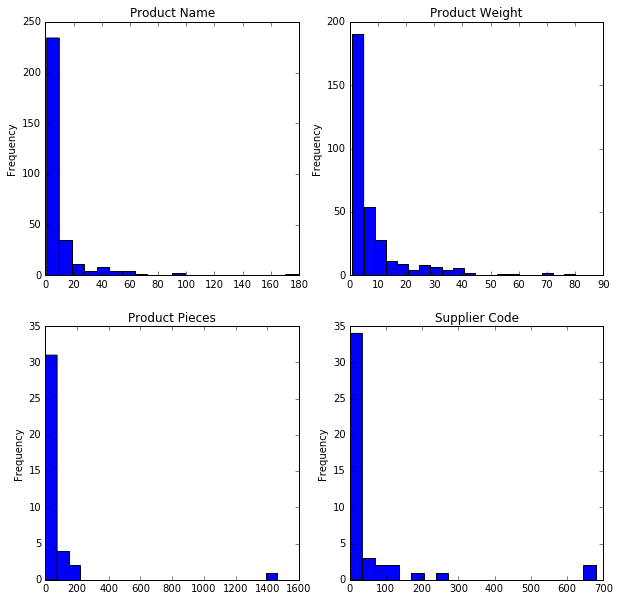

In [5]:
# how a histogram of product names, weights, pieces, supplier
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

df_product['ProductName'].value_counts().plot.hist(ax=axes[0,0],bins=20,sharex=False,title='Product Name')
df_product['ProductWeight'].value_counts().plot.hist(ax=axes[0,1],bins=20,sharex=False,title='Product Weight')
df_product['ProductPieces'].value_counts().plot.hist(ax=axes[1,0],bins=20,sharex=False,title='Product Pieces')
df_product['SupplierCode'].value_counts().plot.hist(ax=axes[1,1],bins=20,sharex=False,title='Supplier Code')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)

In [6]:
# finally let's look at some of the larger count values...
print df_product.groupby(by='ProductName', 
                         as_index=False)['ProductId'].count().sort_values(by='ProductId',ascending=False).head(5)

print df_product.groupby(by='ProductWeight', 
                         as_index=False)['ProductId'].count().sort_values(by='ProductId',ascending=False).head(5)

print df_product.groupby(by='ProductPieces', 
                         as_index=False)['ProductId'].count().sort_values(by='ProductId',ascending=False).head(5)

print df_product.groupby(by='SupplierCode', 
                         as_index=False)['ProductId'].count().sort_values(by='ProductId',ascending=False).head(5)

     ProductName  ProductId
191          Pan        179
99           Duo         96
90    Deliciosas         92
259  Suavicremas         65
275     Tortilla         60
    ProductWeight  ProductId
326            g          80
71          180g          72
269         680g          71
325          None         59
90          200g          53
   ProductPieces  ProductId
36          None       1463
34           8p         164
32           6p         159
19           2p         101
2           10p          90
   SupplierCode  ProductId
4           BIM        679
23          MLA        657
40           TR        257
19          LAR        182
14          GBI        130


### Summary
The product look up has 2,500 approx entries and contains meta data within the name attribute which allows for some feature engineering.